<a href="https://colab.research.google.com/github/RVasconcelosMiguel/PerceptionMapping/blob/main/PMT3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt('/content/data_slam.txt')

# Extract sections of the data
pose_data = data[:, :3]  # Pose variations: Δx, Δy, Δtheta
lidar_data = data[:, 3:]   # LIDAR measurements

# Parameters for LIDAR
angles = np.deg2rad(np.linspace(-30, 30, 61))  # Angles from -30° to 30°

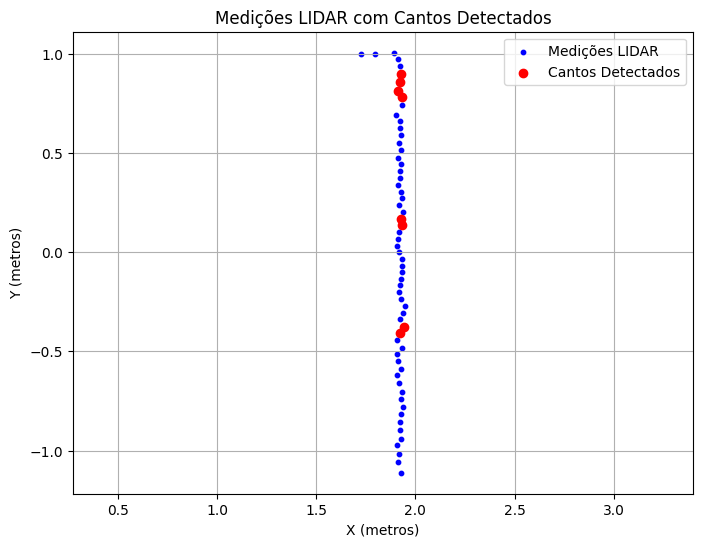

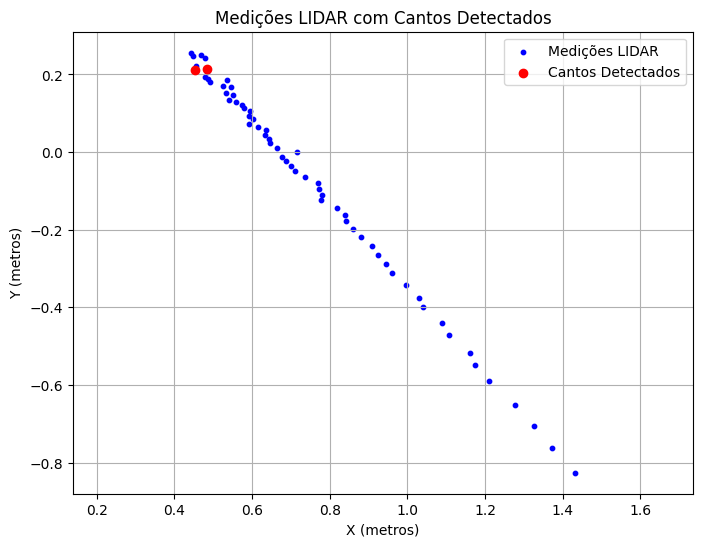

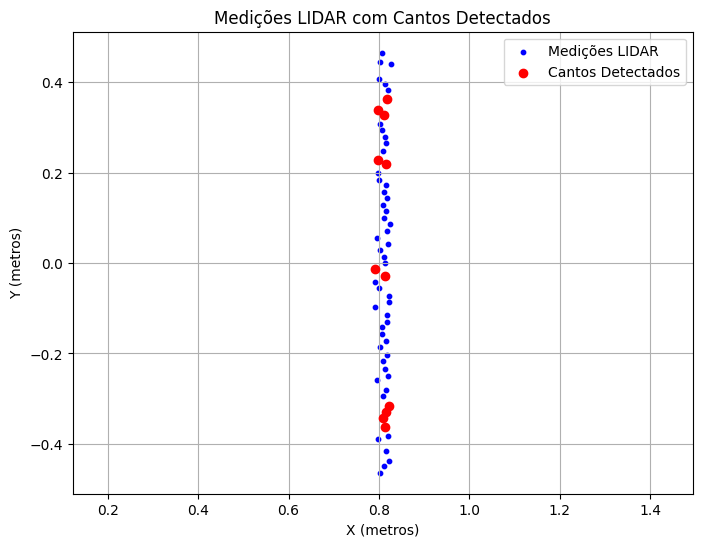

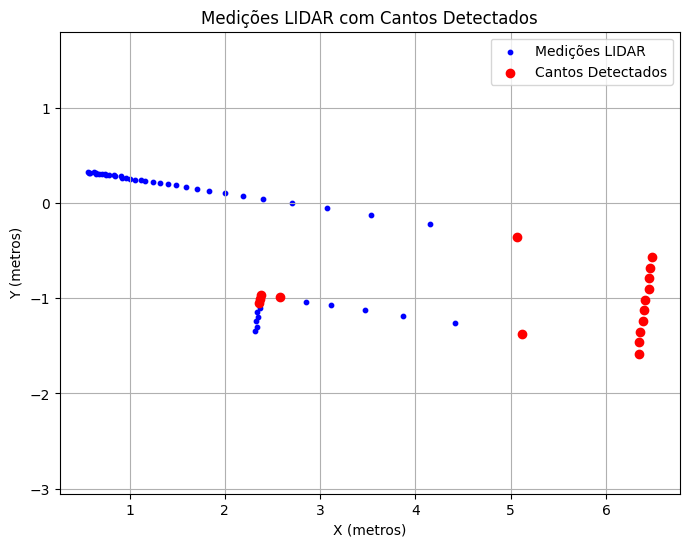

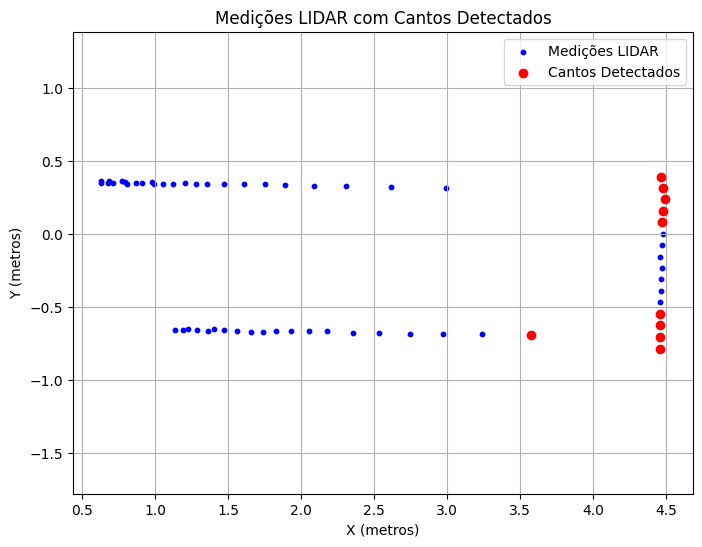

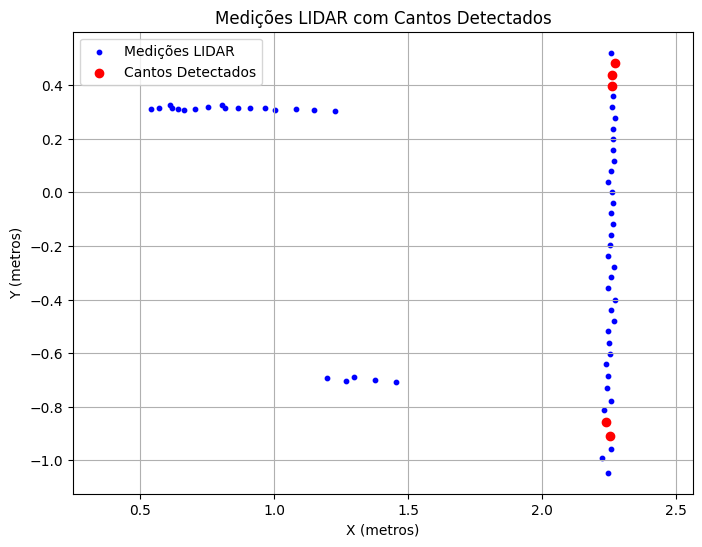

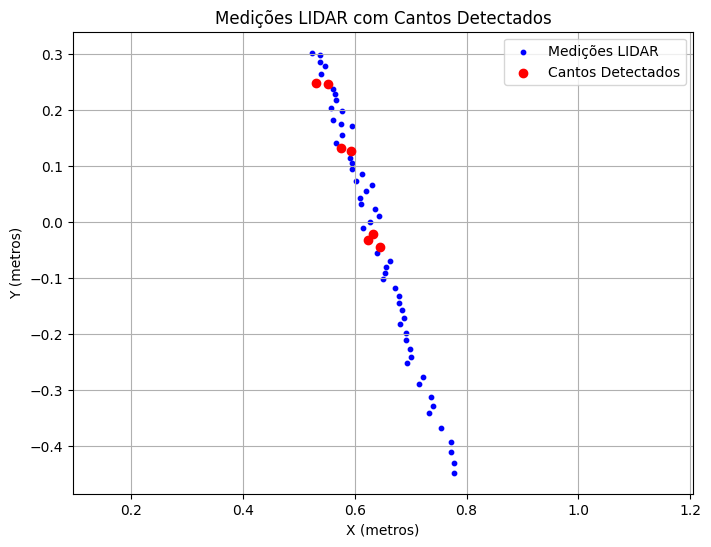

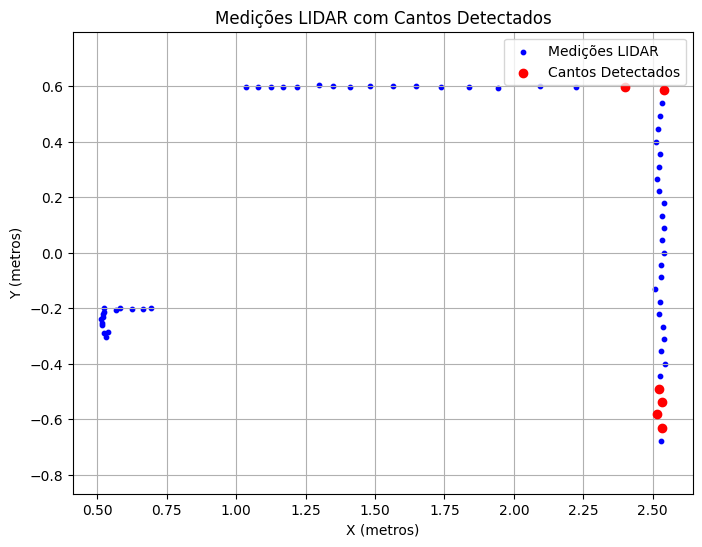

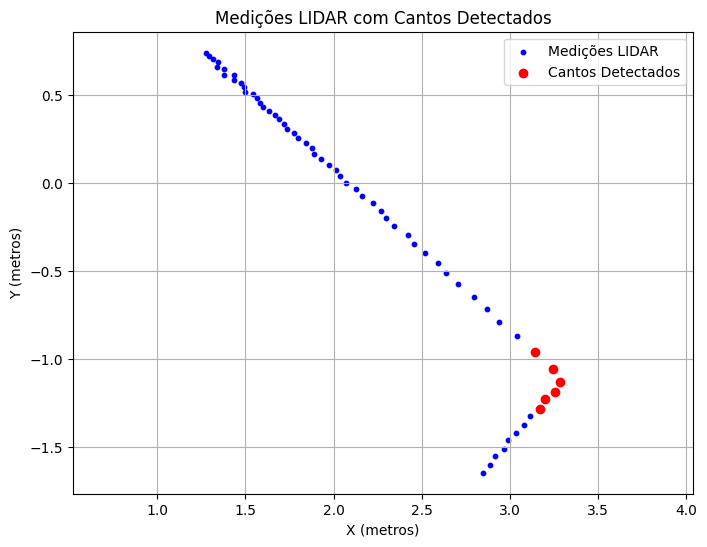

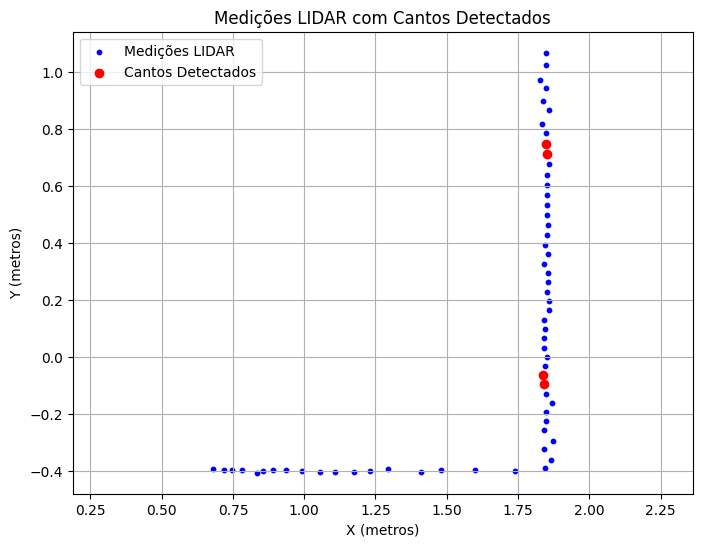

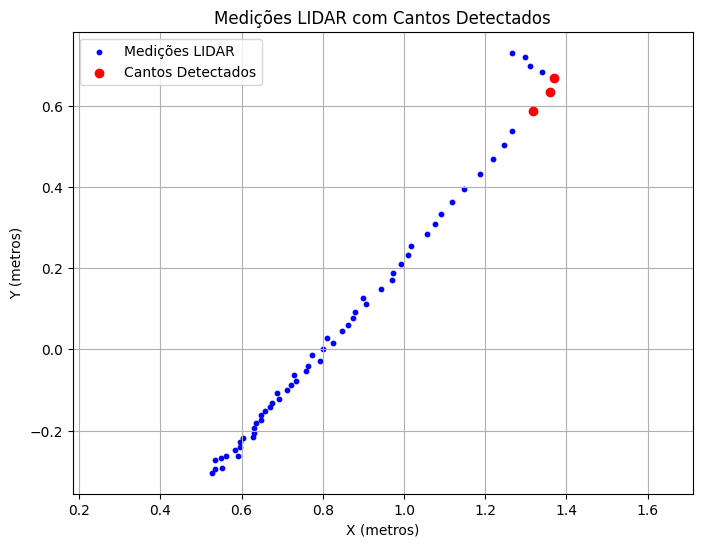

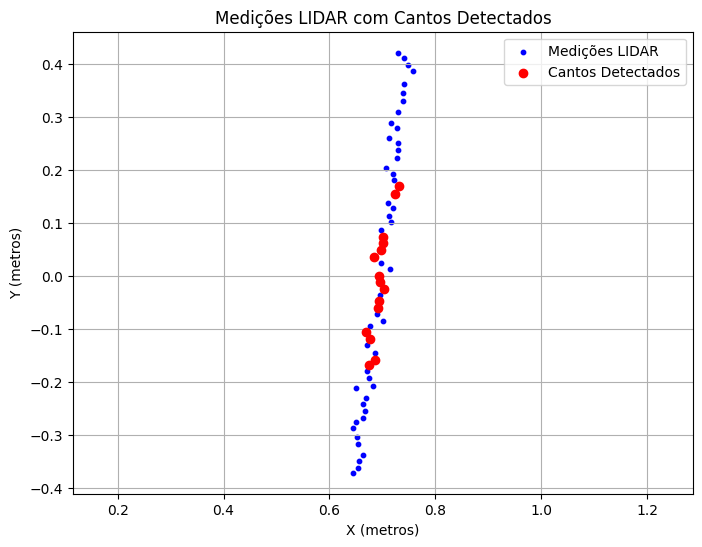

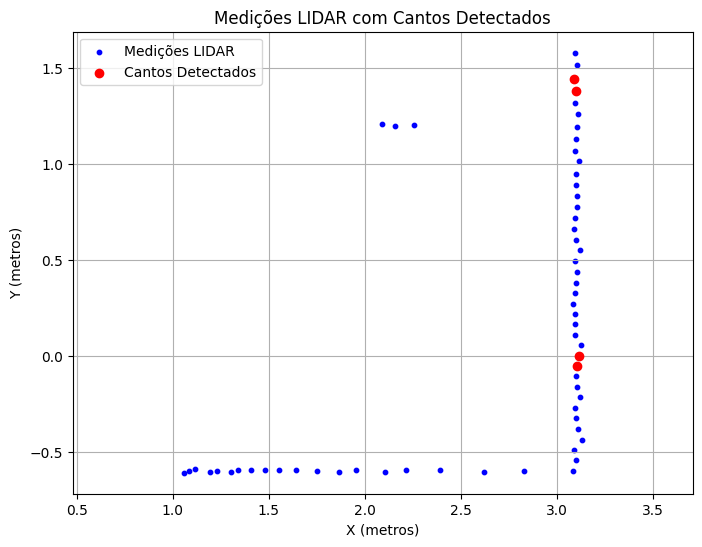

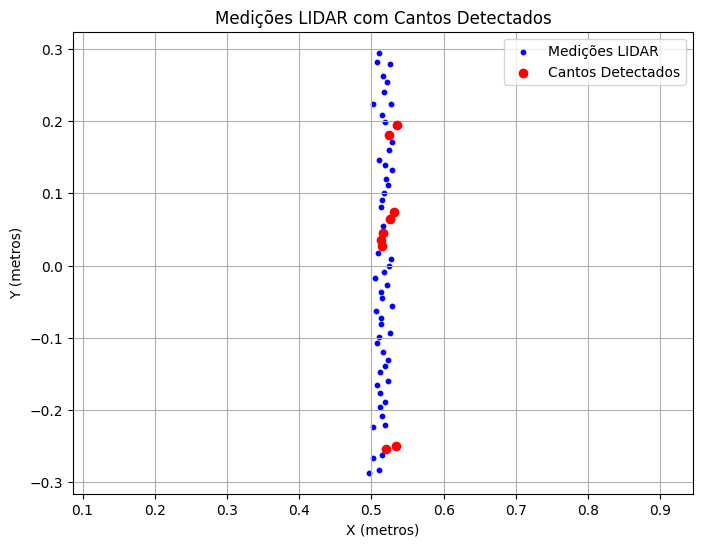

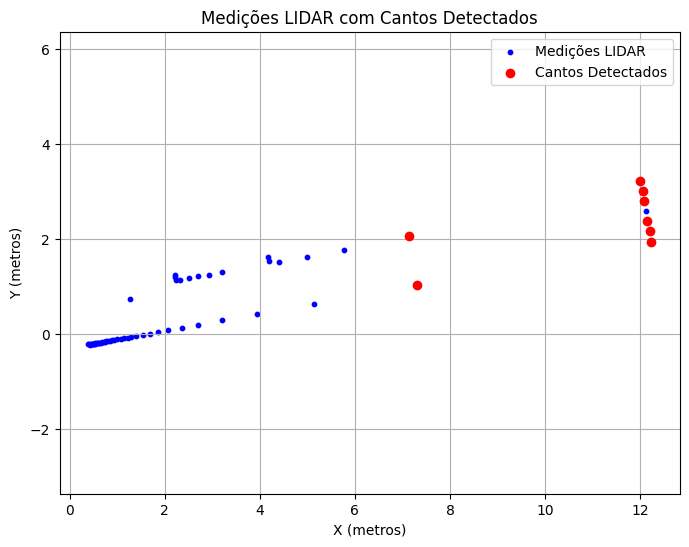

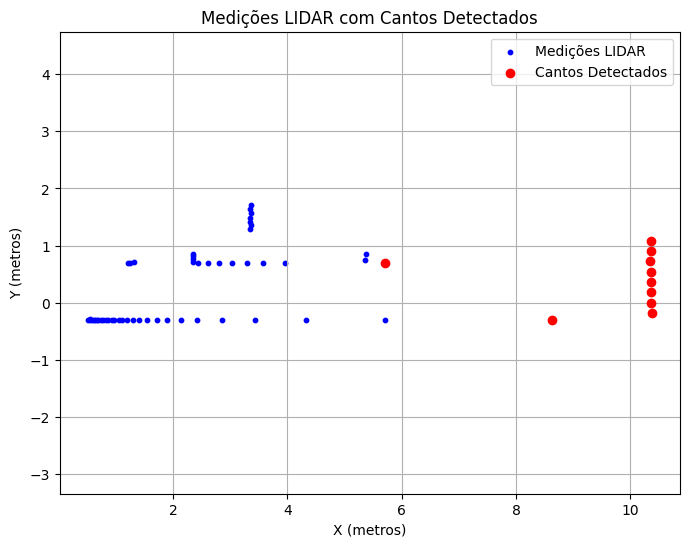

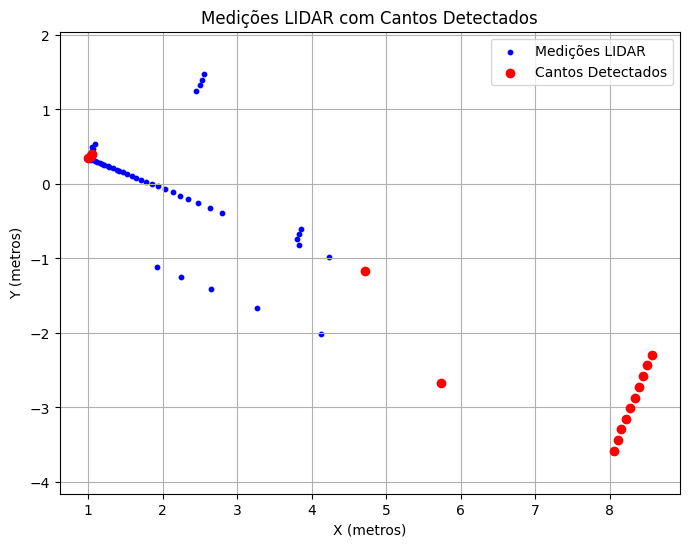

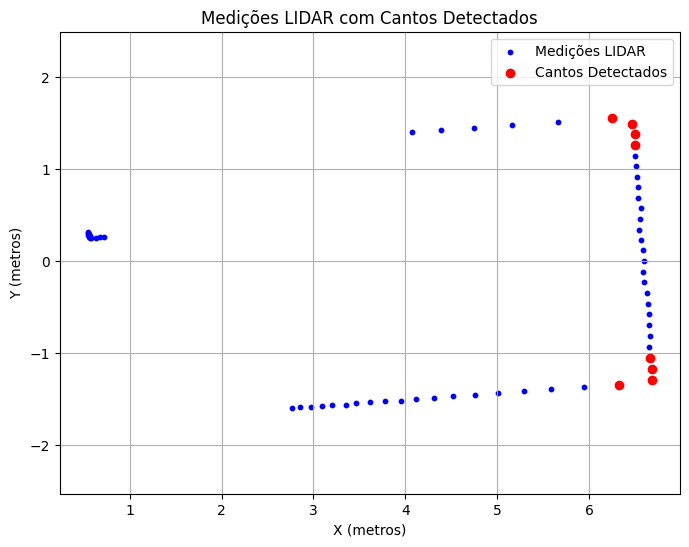

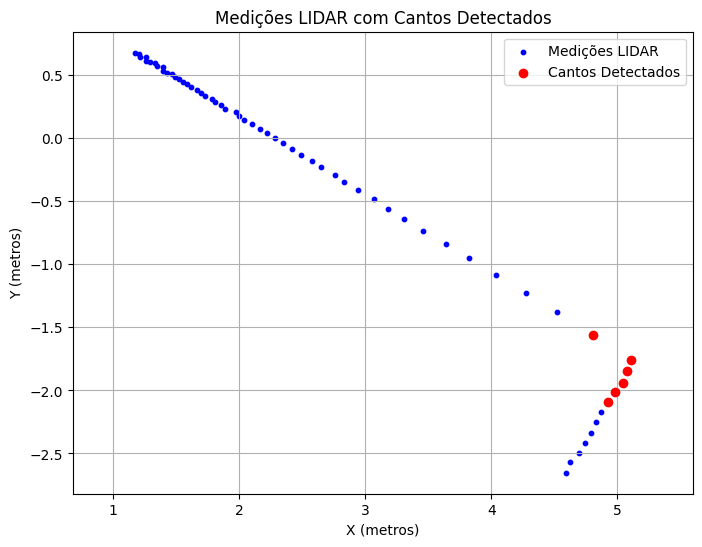

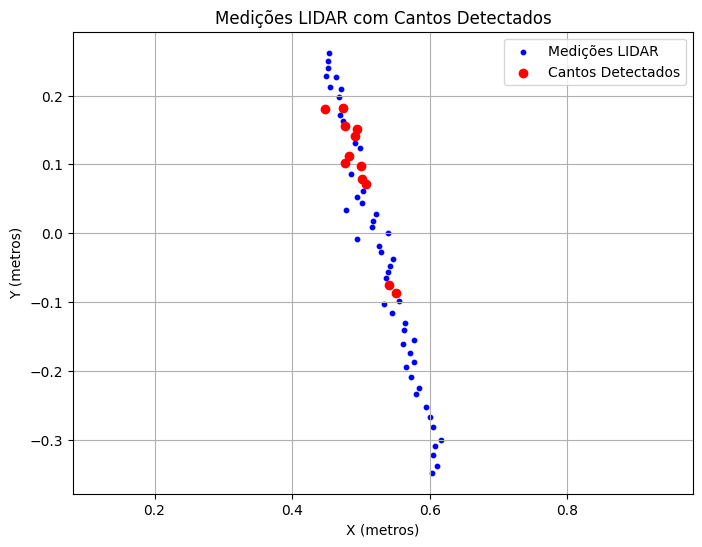

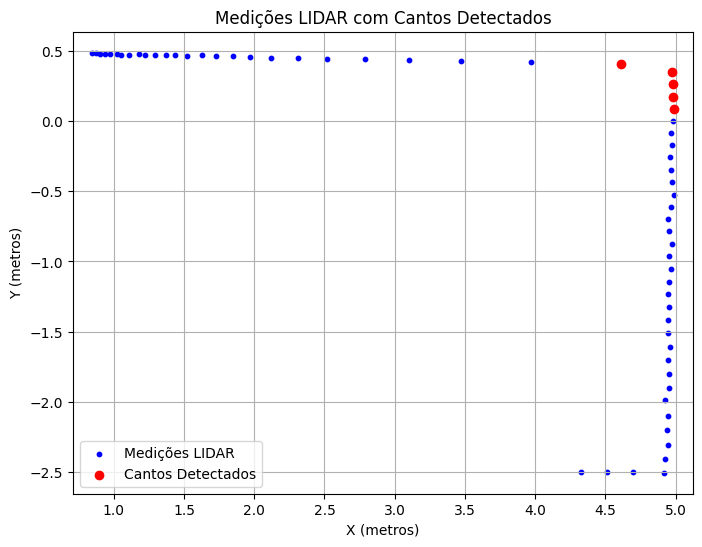

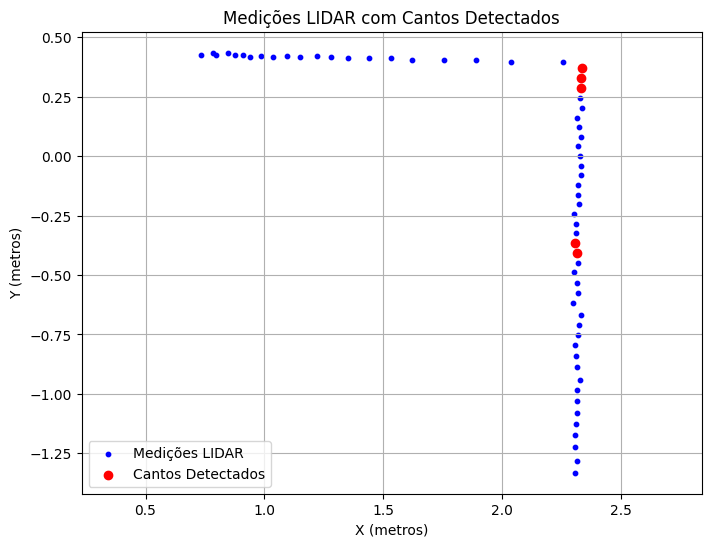

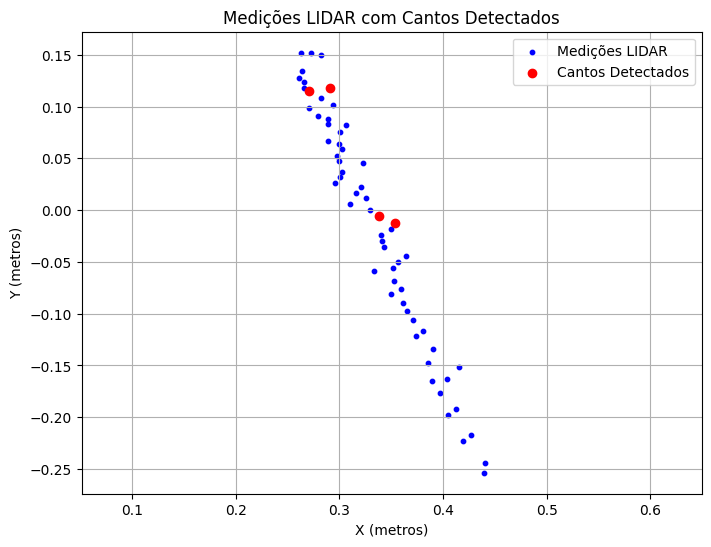

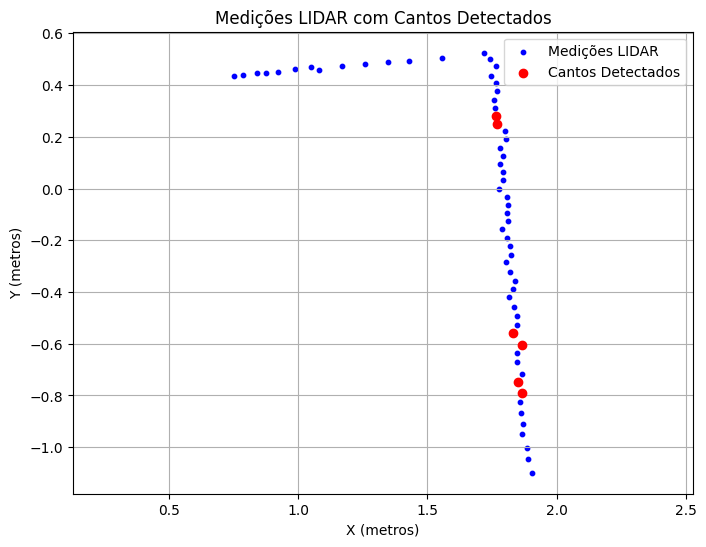

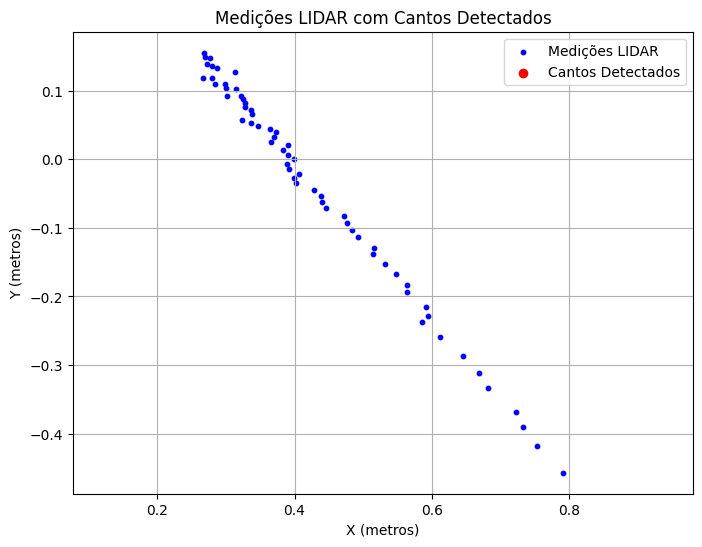

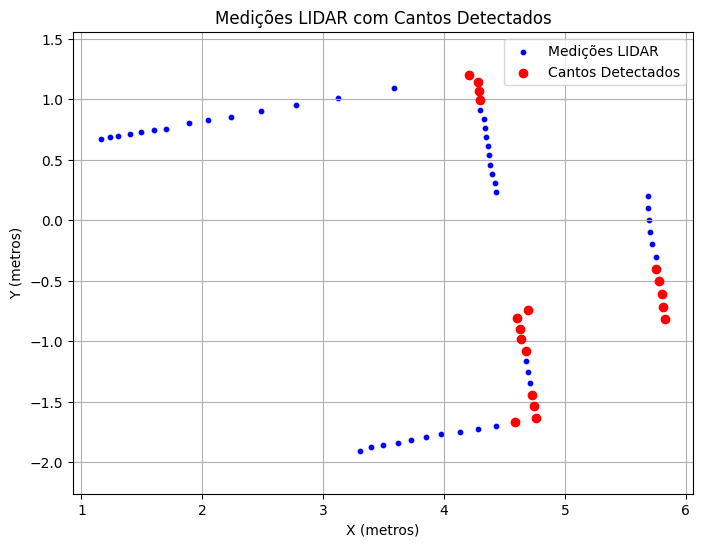

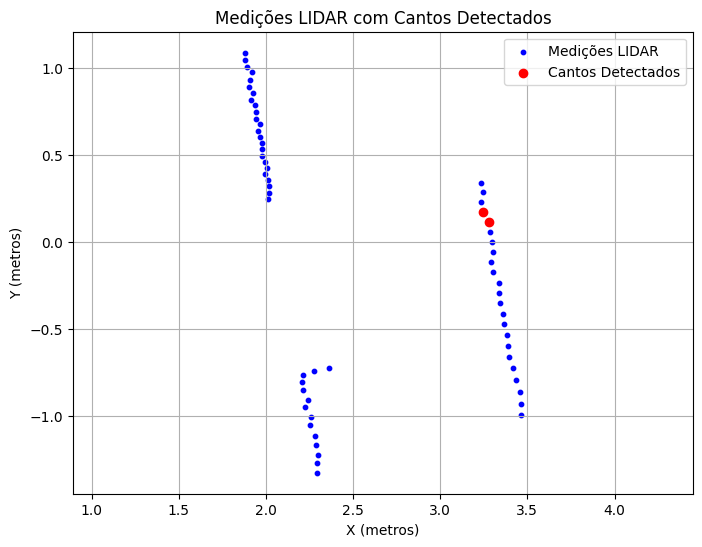

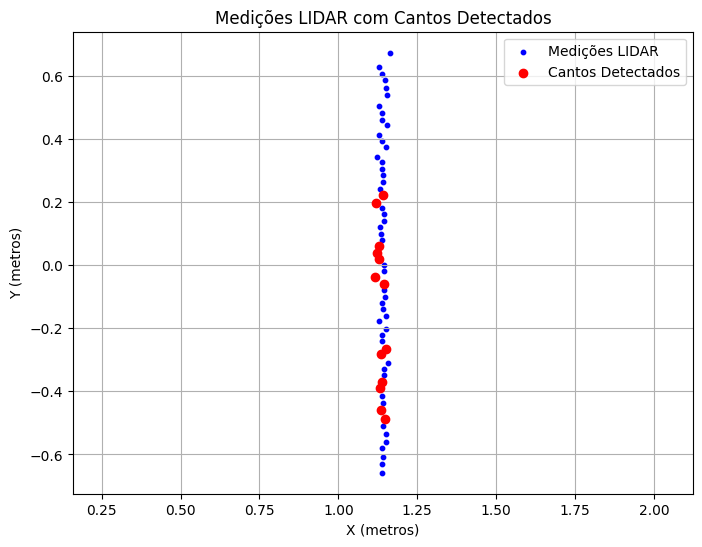

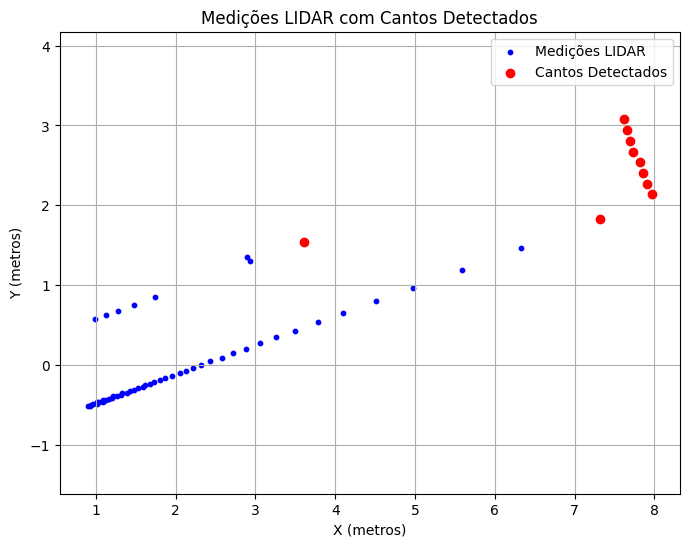

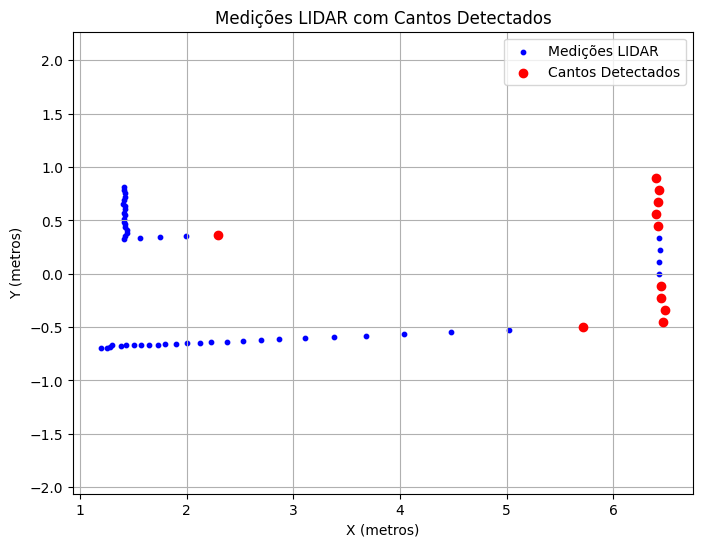

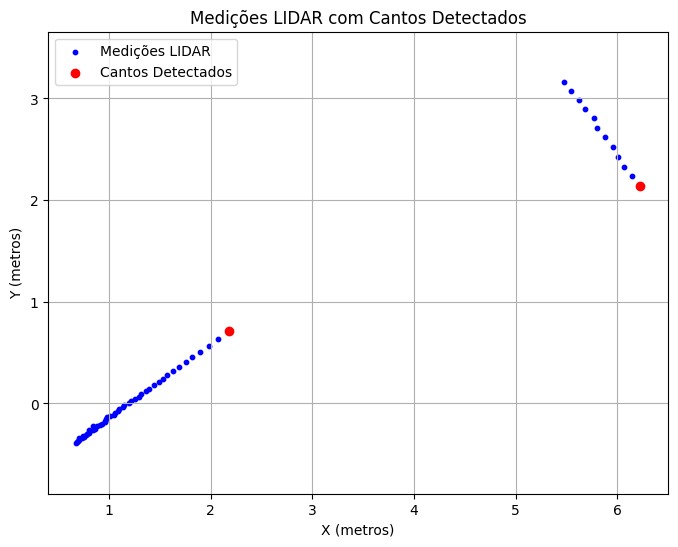

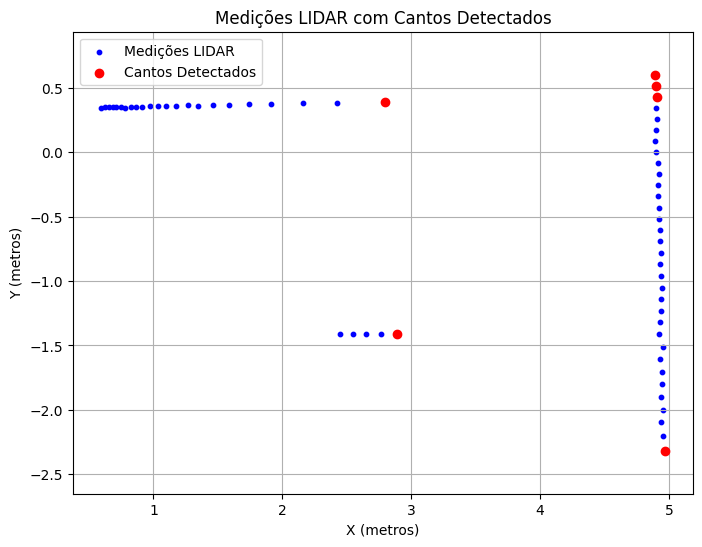

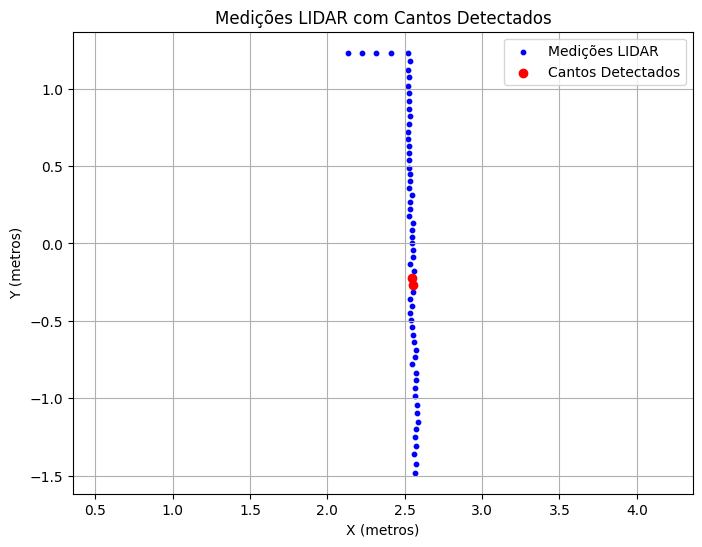

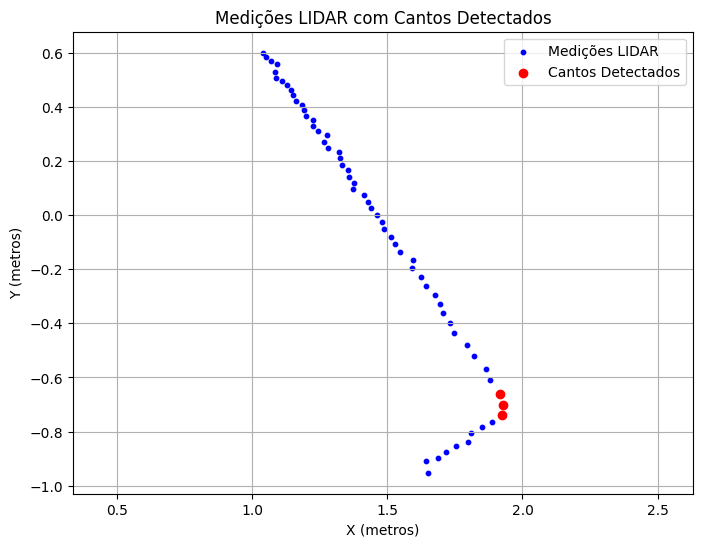

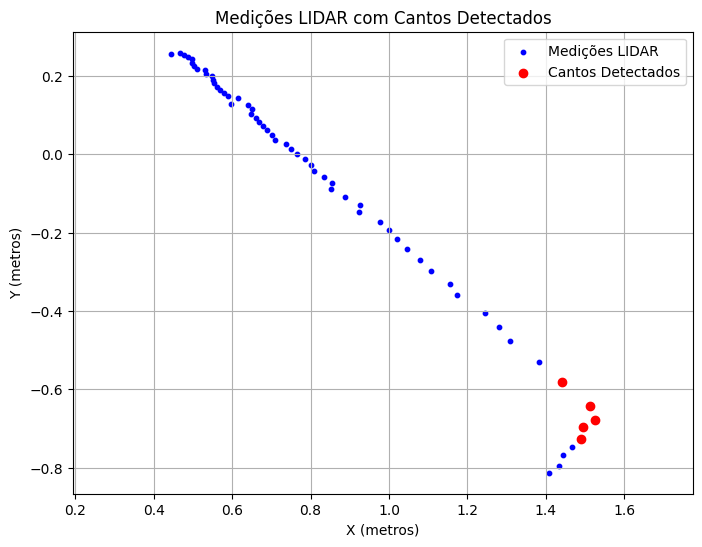

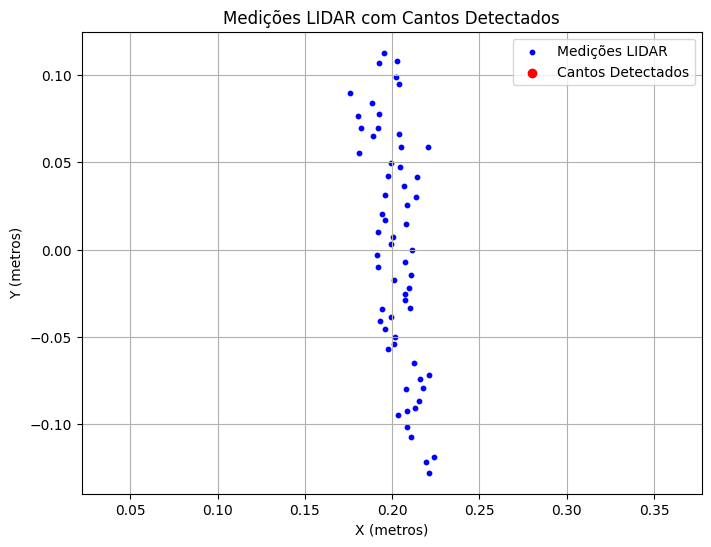

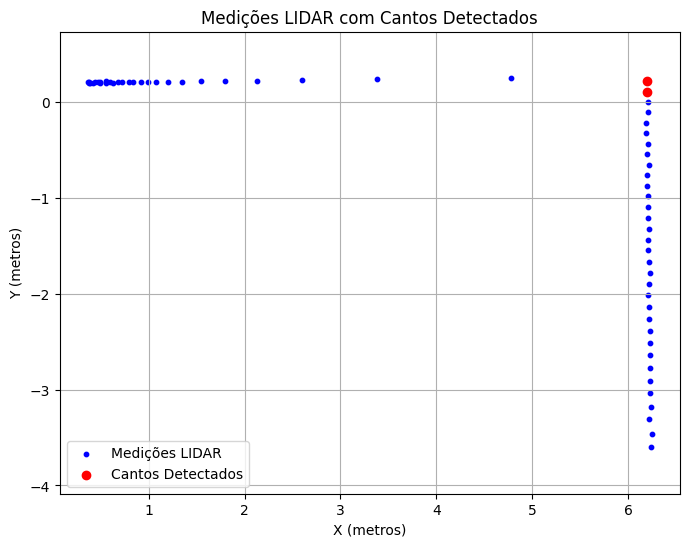

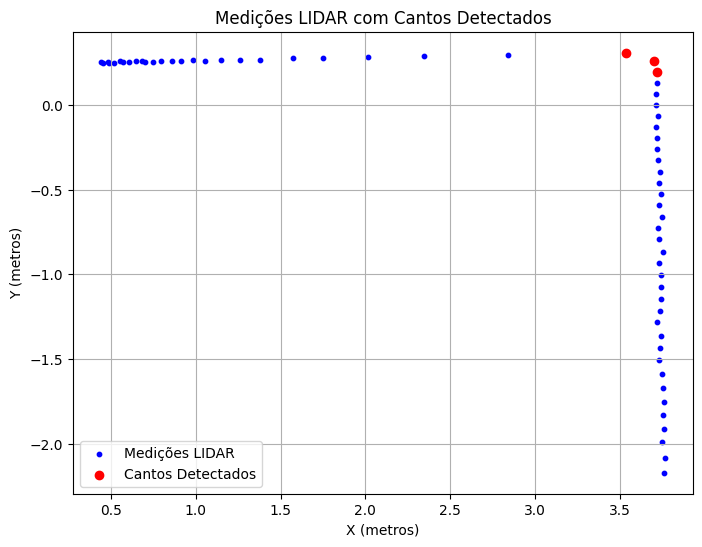

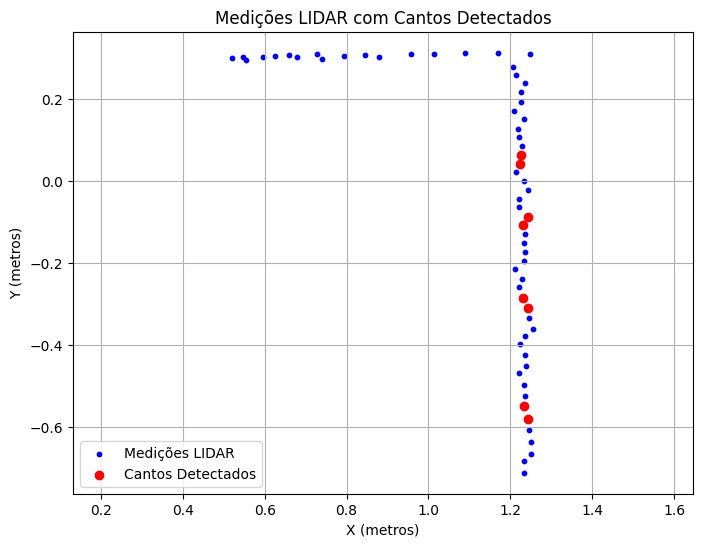

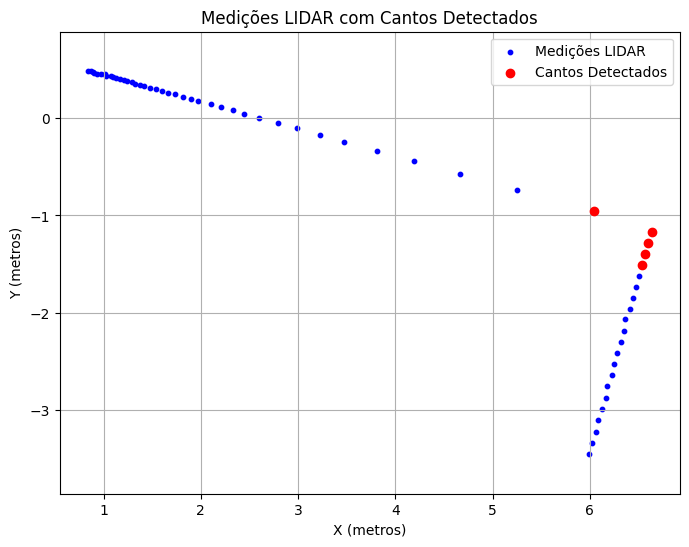

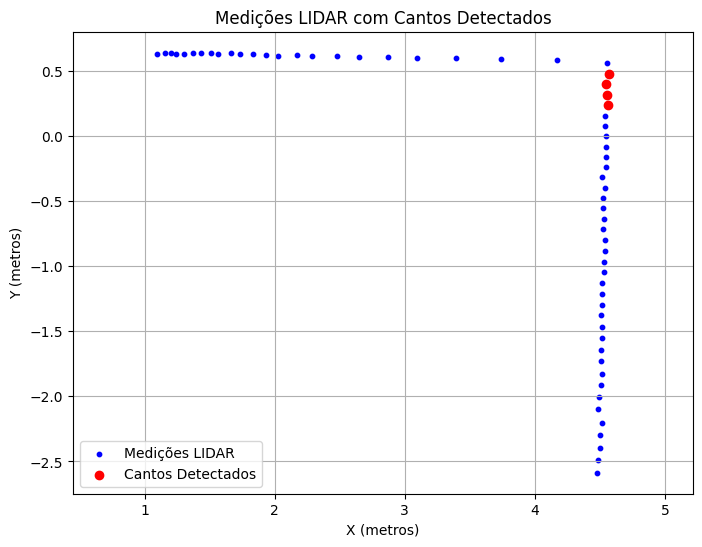

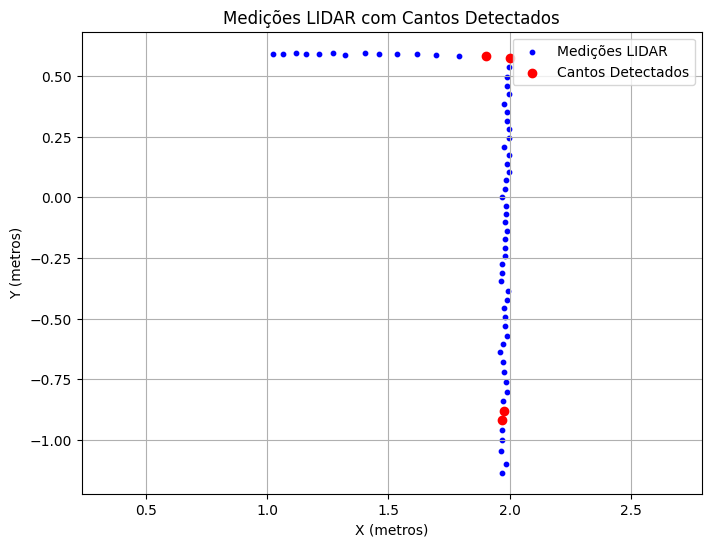

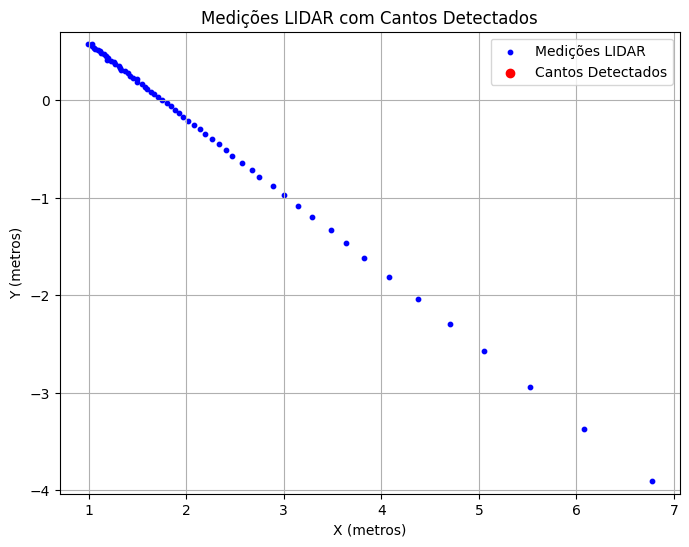

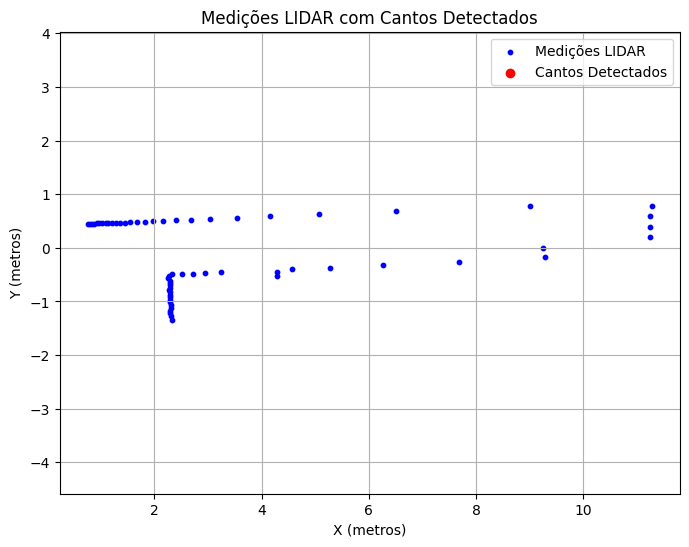

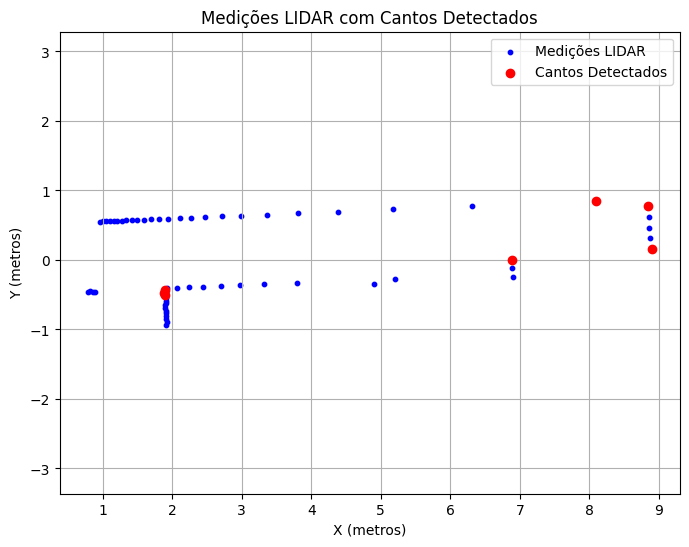

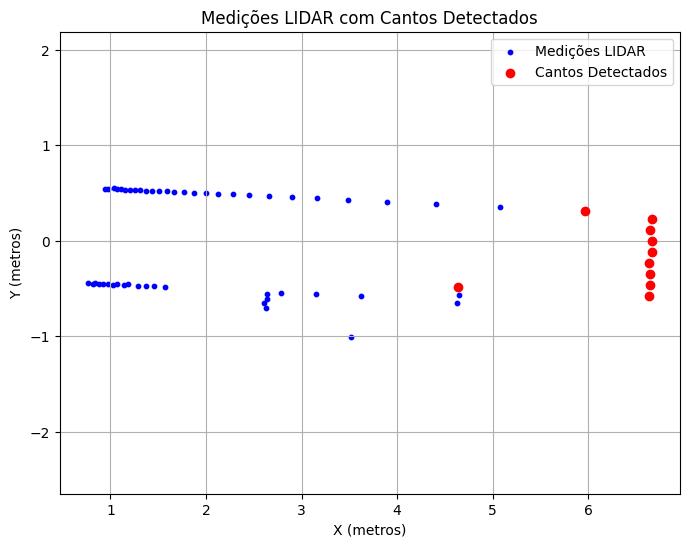

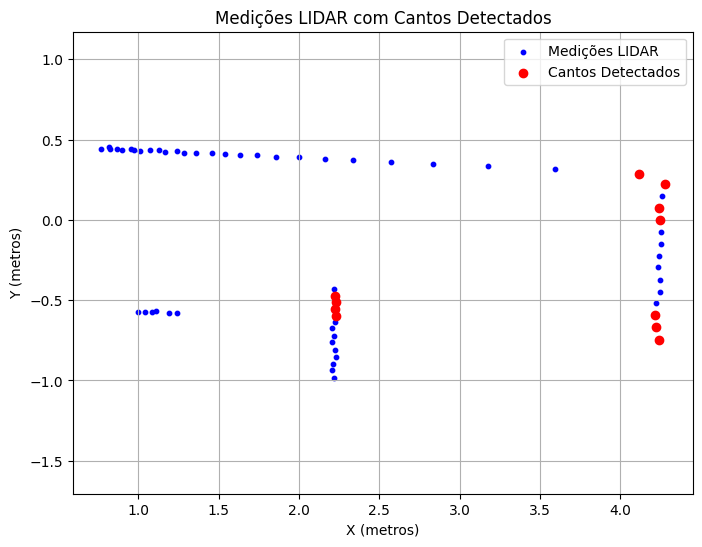

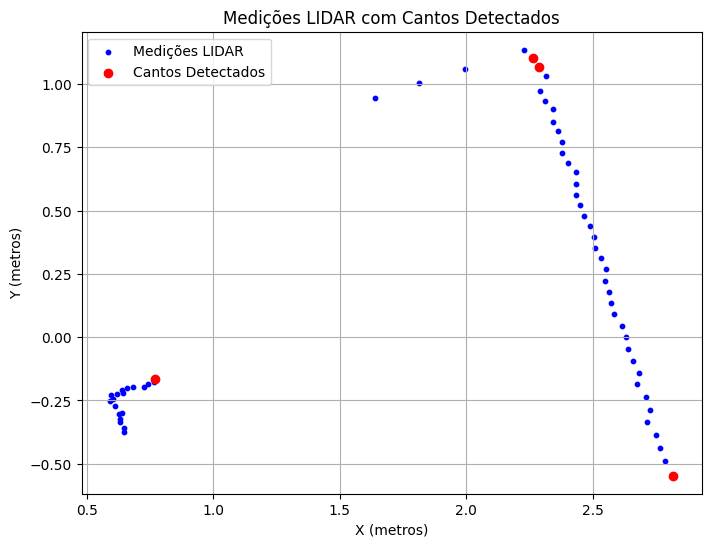

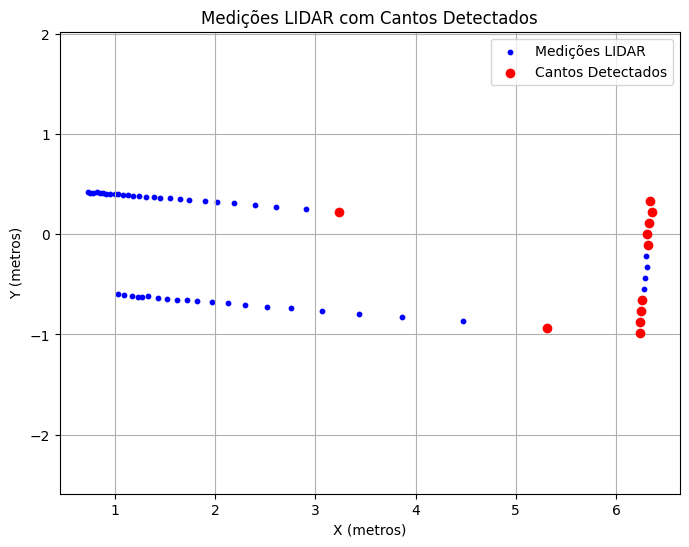

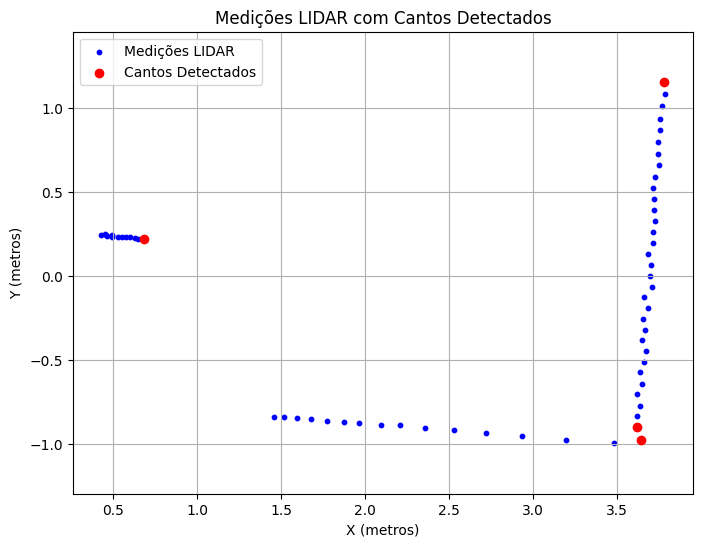

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Função para ajustar uma reta e retornar a inclinação (coeficiente angular)
def compute_slope(x, y):
    A = np.vstack([x, np.ones(len(x))]).T  # Matriz para regressão linear
    m, _ = np.linalg.lstsq(A, y, rcond=None)[0]  # Calcula coeficiente angular (m)
    return m

# Função para calcular a diferença de angulos entre duas inclinações
def slope_to_angle_diff(slope1, slope2):
    angle1 = np.arctan(slope1)  # Converte inclinação para angulo
    angle2 = np.arctan(slope2)
    return np.abs(np.rad2deg(angle2 - angle1))  # Retorna diferença de angulo em graus

# Função para detectar cantos usando regressão linear em clusters maiores
def detect_corners_with_slopes(lidar_data, angles, cluster_size, angle_threshold_max, angle_threshold_min):
    corners = []
    x_coords, y_coords = lidar_to_cartesian(lidar_data, angles)

    # Percorrer os pontos em clusters maiores com sobreposição controlada
    step_size = 1  # Definir que o próximo cluster inicia após o último ponto do cluster anterior
    for i in range(0, len(x_coords) - 2 * cluster_size + 1, step_size):
        # Obter dois clusters consecutivos
        x_cluster_1 = x_coords[i:i + cluster_size]
        y_cluster_1 = y_coords[i:i + cluster_size]

        x_cluster_2 = x_coords[i + cluster_size :i + 2 * cluster_size ]
        y_cluster_2 = y_coords[i + cluster_size :i + 2 * cluster_size ]

        # Calcular inclinação das duas retas ajustadas
        slope_1 = compute_slope(x_cluster_1, y_cluster_1)
        slope_2 = compute_slope(x_cluster_2, y_cluster_2)

        # Verificar se a diferença de angulo é aproximadamente 90°
        angle_diff = slope_to_angle_diff(slope_1, slope_2)
        if np.abs(angle_diff) < angle_threshold_max and np.abs(angle_diff) > angle_threshold_min:
            corners.append(i + cluster_size - 1)  # Ponto final do primeiro cluster
            corners.append(i + cluster_size)      # Ponto inicial do segundo cluster

        # Agora, no próximo ciclo, o segundo cluster será o primeiro cluster do próximo ciclo
        # Para isso, a nova iteração deve começar a partir do índice i + cluster_size
        i += cluster_size - 1  # Atualiza o índice para refletir o deslocamento do próximo ciclo

    return list(set(corners))  # Remove duplicatas



# Função para converter medições LIDAR para coordenadas cartesianas
def lidar_to_cartesian(lidar_data, angles):
    x_coords = lidar_data * np.cos(angles)
    y_coords = lidar_data * np.sin(angles)
    return x_coords, y_coords

# Função para plotar as medições LIDAR com os cantos detectados
def plot_lidar_with_corners(lidar_data, corners, angles):
    # Converter medições LIDAR para coordenadas cartesianas
    x_coords, y_coords = lidar_to_cartesian(lidar_data, angles)

    # Obter coordenadas dos cantos detectados
    corner_x, corner_y = x_coords[corners], y_coords[corners]

    # Plotar o gráfico
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, s=10, label="Medições LIDAR", color='b')
    plt.scatter(corner_x, corner_y, color='r', label="Cantos Detectados", zorder=5)
    plt.axis("equal")
    plt.title("Medições LIDAR com Cantos Detectados")
    plt.xlabel("X (metros)")
    plt.ylabel("Y (metros)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Parâmetros iniciaisangle_threshold_max
angles = np.deg2rad(np.linspace(-30, 30, 61))  # Angulos de -30° a 30°
angle_threshold_max= 100 # Margem de erro para detectar 90°
angle_threshold_min =80
cluster_size = 5  # Tamanho dos clusters

# Iterar sobre as leituras LIDAR
for i in range(len(lidar_data)):
    lidar_row = lidar_data[i]  # Medidas LIDAR da linha atual

    # Detectar cantos usando regressão linear com diferenças de angulos
    corners = detect_corners_with_slopes(lidar_row, angles, cluster_size, angle_threshold_max,angle_threshold_min)

    # Plotar resultados
    plot_lidar_with_corners(lidar_row, corners, angles)


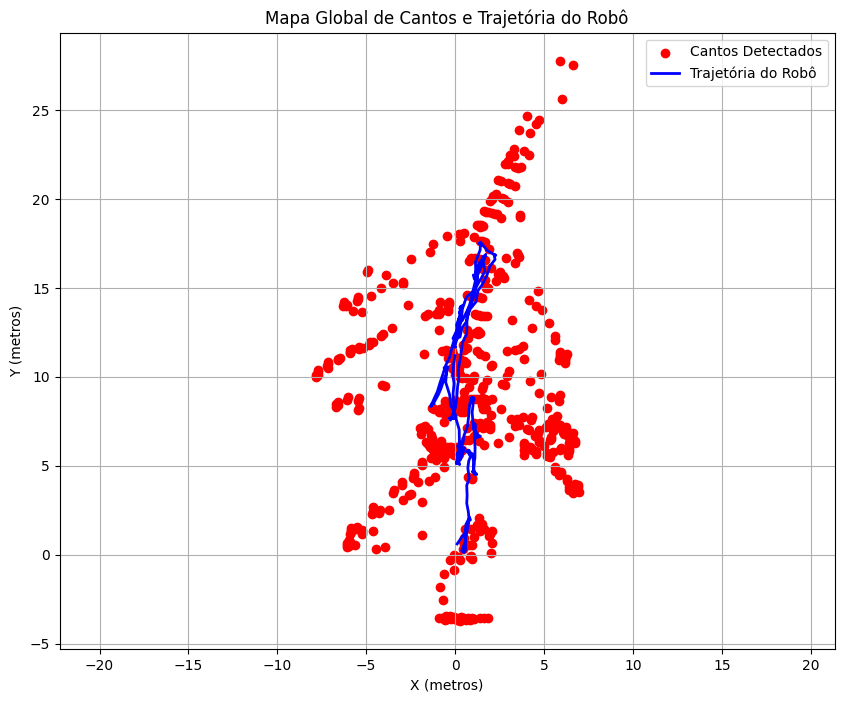

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Inicializar filtro de partículas
N = 100  # Número de partículas
particles = np.random.normal(loc=0, scale=0.1, size=(N, 3))  # Partículas: [x, y, theta]
weights = np.ones(N) / N  # Pesos uniformes iniciais

# Inicializar mapa global de cantos
map_corners = []  # Lista de cantos conhecidos no sistema global
corner_threshold = 0.1  # Distância limite para considerar um canto como conhecido

# Lista para armazenar as poses estimadas do robô
robot_trajectory = []

# Função para atualizar partículas com base no movimento
def predict_particles(particles, delta_pose, motion_noise):
    for i in range(len(particles)):
        x, y, theta = particles[i]
        dx = delta_pose[0] + np.random.normal(0, motion_noise[0])
        dy = delta_pose[1] + np.random.normal(0, motion_noise[1])
        dtheta = delta_pose[2] + np.random.normal(0, motion_noise[2])
        dx_global = dx * np.cos(theta) - dy * np.sin(theta)
        dy_global = dx * np.sin(theta) + dy * np.cos(theta)
        particles[i, 0] = x + dx_global
        particles[i, 1] = y + dy_global
        particles[i, 2] = theta + dtheta
    return particles

# Função para calcular pesos das partículas com base nas medições LIDAR
def update_weights(particles, weights, lidar_readings, map_corners, measurement_noise):
    for i, particle in enumerate(particles):
        simulated_corners = []
        for corner in map_corners:
            dx = corner[0] - particle[0]
            dy = corner[1] - particle[1]
            simulated_corners.append(np.sqrt(dx**2 + dy**2))
        if simulated_corners:
            simulated_readings = np.min(simulated_corners, axis=0)
            weights[i] *= np.exp(-np.sum((lidar_readings - simulated_readings)**2) / (2 * measurement_noise**2))
    weights_sum = np.sum(weights)
    if weights_sum > 0:
        weights /= weights_sum
    else:
        weights = np.ones(len(weights)) / len(weights)  # Reiniciar pesos uniformes se todos forem zero
    return weights

# Reamostragem de partículas
def resample_particles(particles, weights):
    if np.any(np.isnan(weights)) or np.sum(weights) == 0:
        weights = np.ones(len(weights)) / len(weights)  # Reiniciar pesos uniformes
    indices = np.random.choice(len(particles), size=len(particles), p=weights)
    return particles[indices], np.ones(len(particles)) / len(particles)

# Função para verificar se um canto é conhecido
def is_known_corner(corner, map_corners, threshold):
    for known_corner in map_corners:
        if np.linalg.norm(np.array(corner) - np.array(known_corner)) < threshold:
            return True
    return False

# Função para converter coordenadas locais para globais
def local_to_global(local_points, pose):
    x_local, y_local = local_points
    x_global = pose[0] + x_local * np.cos(pose[2]) - y_local * np.sin(pose[2])
    y_global = pose[1] + x_local * np.sin(pose[2]) + y_local * np.cos(pose[2])
    return x_global, y_global

# Iterar sobre os dados
for t in range(len(pose_data)):
    delta_pose = pose_data[t]
    motion_noise = [0.02, 0.02, 0.01]
    particles = predict_particles(particles, delta_pose, motion_noise)

    lidar_row = lidar_data[t]
    #lidar_row_smoothed = smooth_lidar_data(lidar_row, window_size=5)

    corners_local = detect_corners_with_slopes(lidar_row, angles, cluster_size, angle_threshold_max,angle_threshold_min)
    x_local, y_local = lidar_to_cartesian(lidar_row[corners_local], angles[corners_local])

    weights = update_weights(particles, weights, lidar_row[corners_local], map_corners, measurement_noise=0.1)
    particles, weights = resample_particles(particles, weights)

    robot_pose = np.average(particles, axis=0, weights=weights)

    # Salvar a pose do robô para a trajetória
    robot_trajectory.append((robot_pose[0], robot_pose[1]))

    x_global, y_global = local_to_global((x_local, y_local), robot_pose)

    for corner in zip(x_global, y_global):
        if not is_known_corner(corner, map_corners, corner_threshold):
            map_corners.append(corner)

# Converter a trajetória para arrays separados de coordenadas X e Y
trajectory_x, trajectory_y = zip(*robot_trajectory)

# Plotar o mapa global final com a trajetória
plt.figure(figsize=(10, 8))
plt.scatter(*zip(*map_corners), c='r', label='Cantos Detectados')
plt.plot(trajectory_x, trajectory_y, c='b', label='Trajetória do Robô', linewidth=2)
plt.title("Mapa Global de Cantos e Trajetória do Robô")
plt.xlabel("X (metros)")
plt.ylabel("Y (metros)")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#'/content/data_slam.txt'

# --- Funções Auxiliares ---
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados
file_path = '/content/data_slam.txt'
data = np.loadtxt(file_path)

# Extrair as variações de pose (Δx, Δy, Δθ) e os dados do LIDAR
pose_data = data[:, :3]  # Pose variations: Δx, Δy, Δθ
lidar_data = data[:, 3:]  # LIDAR measurements

# Parâmetros do LIDAR
angles = np.deg2rad(np.linspace(-30, 30, 61))  # Ângulos entre -30° e 30°

# --- Funções Auxiliares ---
def transform_lidar_to_global(lidar_distances, robot_pose, angles):
    """Transforma as medições do LIDAR para o referencial global."""
    x, y, theta = robot_pose
    lidar_x = lidar_distances * np.cos(angles)  # Coordenadas locais x
    lidar_y = lidar_distances * np.sin(angles)  # Coordenadas locais y

    # Transformação para o referencial global
    global_x = x + np.cos(theta) * lidar_x - np.sin(theta) * lidar_y
    global_y = y + np.sin(theta) * lidar_x + np.cos(theta) * lidar_y
    return global_x, global_y

# --- Filtro de Kalman Estendido (EKF) ---
def ekf_predict(state, covariance, delta_pose, motion_noise):
    """Predição do estado e da covariância no EKF."""
    x, y, theta = state
    dx, dy, dtheta = delta_pose

    # Prever o novo estado com o modelo de movimento
    predicted_state = np.array([
        x + dx * np.cos(theta) - dy * np.sin(theta),
        y + dx * np.sin(theta) + dy * np.cos(theta),
        theta + dtheta
    ])

    # Linearizar o modelo de movimento (Jacobian)
    F = np.array([
        [1, 0, -dx * np.sin(theta) - dy * np.cos(theta)],
        [0, 1,  dx * np.cos(theta) - dy * np.sin(theta)],
        [0, 0, 1]
    ])

    # Atualizar a covariância com ruído de movimento
    predicted_covariance = F @ covariance @ F.T + motion_noise

    return predicted_state, predicted_covariance

def ekf_update(state, covariance, lidar_distances, angles, map_points, measurement_noise):
    """Atualização do estado e da covariância no EKF."""
    x, y, theta = state

    # Prever medições no referencial global
    predicted_x, predicted_y = transform_lidar_to_global(lidar_distances, state, angles)
    predicted_measurements = np.vstack((predicted_x, predicted_y)).T

    # Encontrar os pontos mais próximos no mapa para cada medição LIDAR
    map_points = np.array(map_points).T  # (2, N) -> (N, 2)
    associated_map_points = []
    for pm in predicted_measurements:
        distances = np.linalg.norm(map_points - pm, axis=1)
        closest_idx = np.argmin(distances)
        associated_map_points.append(map_points[closest_idx])
    associated_map_points = np.array(associated_map_points)

    # Innovation/residual
    z = associated_map_points
    z_hat = predicted_measurements
    y_residual = z - z_hat

    # Linearizar o modelo de medição (Jacobian)
    H = np.array([
        [1, 0, -lidar_distances.mean() * np.sin(theta)],
        [0, 1,  lidar_distances.mean() * np.cos(theta)]
    ])

    # Kalman Gain
    S = H @ covariance @ H.T + measurement_noise
    K = covariance @ H.T @ np.linalg.inv(S)

    # Atualizar estado e covariância
    updated_state = state + np.mean(K @ y_residual.T, axis=1)
    updated_covariance = (np.eye(len(state)) - K @ H) @ covariance

    return updated_state, updated_covariance

# --- Inicialização ---
# Estado inicial e covariância
state = np.array([0, 0, 0])  # [x, y, θ]
covariance = np.eye(3) * 0.1

# Ruídos
motion_noise = np.diag([0.1, 0.1, 0.05])  # Ruído no movimento
measurement_noise = np.diag([0.5, 0.5])  # Ruído na medição

# Trajetória e mapa
poses = [state]
map_x, map_y = [], []

# --- EKF SLAM ---
for t in range(len(pose_data)):
    # Predição
    delta_pose = pose_data[t]
    state, covariance = ekf_predict(state, covariance, delta_pose, motion_noise)

    # Atualização
    if len(map_x) > 0:
        map_points = [map_x, map_y]
        state, covariance = ekf_update(state, covariance, lidar_data[t], angles, map_points, measurement_noise)

    # Atualizar mapa com novos pontos LIDAR
    lidar_x, lidar_y = transform_lidar_to_global(lidar_data[t], state, angles)
    map_x.extend(lidar_x)
    map_y.extend(lidar_y)

    # Salvar pose
    poses.append(state)

# Converter poses para array
poses = np.array(poses)

# --- Visualização ---
# Trajetória estimada
plt.figure(figsize=(10, 6))
plt.plot(poses[:, 0], poses[:, 1], label="Trajetória Estimada", color="red")

# Mapa estimado
plt.scatter(map_x, map_y, s=2, c='blue', label="Pontos do Mapa")

# Formatação do gráfico
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("SLAM com EKF")
plt.legend()
plt.axis('equal')
plt.grid()
plt.show()
